In [1]:
import os
import sys
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(repo_root)

from src.utils.file_handlers import read_file_parameters

In [ ]:
def file_handlers(): 
    data_path = os.path.join(os.getcwd(), 'data')

    all_results = []
    for file in os.listdir(data_path):

        id, _ = file.split('_data.csv')
        if file.endswith('.csv'):
      
            
            file_path = os.path.join(data_path, file)
            df = pd.read_csv(file_path)



            result = {
                    'dataset':id, 
                    'avg_Ours': df['Ours'].mean(), 
                    'avg_Zermello': df['Zermello'].mean(),
                    'higher_order_speedup': df['Zermello'].mean() / df['Ours'].mean(),

                    'avg_Ours_bin': df['Ours_bin'].mean(),
                    'avg_Zermello_bin' : df['Zermello_bin'].mean(),
                    'binary_speedup': df['Zermello_bin'].mean() / df['Ours_bin'].mean()
                      }

            all_results.append(result)

    final_df = pd.DataFrame(all_results)
    final_df['dataset'] = pd.to_numeric(final_df['dataset'], errors='coerce')
    return final_df.sort_values(by='dataset')

In [11]:
df = file_handlers()
df.to_csv('results/Convergence_Table.csv')
display(df.style.hide(axis='index'))

dataset,avg_Ours,avg_Zermello,higher_order_speedup,avg_Ours_bin,avg_Zermello_bin,binary_speedup
9,6.950000,600.150000,86.352518,7.200000,2987.850000,414.979167
14,14.700000,28.500000,1.938776,13.950000,99.100000,7.103943
28,7.200000,16.100000,2.236111,7.150000,35.350000,4.944056
45,28.600000,34.200000,1.195804,35.900000,544.100000,15.155989
52,89.000000,127.350000,1.430899,154.650000,986.400000,6.378274
100,18.850000,54.350000,2.883289,27.450000,258.700000,9.424408
102,11.150000,58.150000,5.215247,10.450000,123.700000,11.837321
103,9.150000,49.300000,5.387978,9.000000,85.650000,9.516667
104,17.000000,85.250000,5.014706,28.400000,372.750000,13.125000


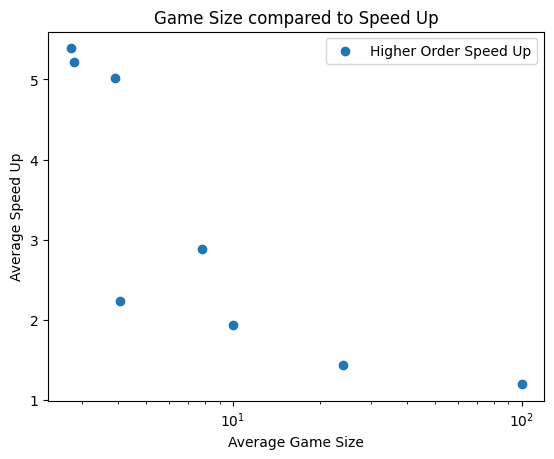

In [10]:
info_table = pd.read_csv(os.path.join(repo_root, 'datasets', 'dataset_info.csv'))
merged_df = pd.merge(info_table, df, left_on='dataset_id', right_on='dataset')
merged_df = merged_df[merged_df['dataset'] != 9]
plt.title('Game Size compared to Speed Up')
plt.scatter(merged_df['K_avg'], merged_df['higher_order_speedup'], label='Higher Order Speed Up')
# plt.scatter(merged_df['K_avg'], merged_df['binary_speedup'], c='red', label='Binary Speed Up')
plt.xscale('log')
plt.ylabel('Average Speed Up')
plt.xlabel('Average Game Size')
plt.legend()

plt.show()
